# Model Training

This notebook this trains and explores various machine learning models

## Data Processing & Loading

In [1]:
# src/data.py

import os
from pathlib import Path

import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T


# move up one level from the current directory
os.chdir(Path.cwd().parent)

print("Working directory set to:", Path.cwd())

Working directory set to: /Users/sarvesh/Desktop/GitHub/lego-minifigure-finder


In [2]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]



def _tfms(image_size=224):
    train = T.Compose([
        T.Resize(int(image_size * 1.14)),
        T.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
    eval_ = T.Compose([
        T.Resize(int(image_size * 1.14)),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
    return {"train": train, "val": eval_, "test": eval_}



class CSVDataset(Dataset):
    def __init__(self, csv_path, img_dir, transforms=None):
        self.df = pd.read_csv(csv_path)
        if not {"filename","label"}.issubset(self.df.columns):
            raise ValueError(f"{csv_path} must have 'filename' and 'label' columns.")
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.img_dir, str(row["filename"]))
        img = Image.open(path).convert("RGB")
        y = int(row["label"])
        if self.transforms: img = self.transforms(img)
        return img, y



def make_loaders(
    data_dir="data",
    images_subdir="images",
    batch_size=32,
    num_workers=0,         # macOS: start at 0; bump later if stable
    image_size=224,
):
    csvs = {
        "train": os.path.join(data_dir, "train.csv"),
        "val":   os.path.join(data_dir, "val.csv"),
        "test":  os.path.join(data_dir, "test.csv"),
    }
    img_dir = os.path.join(data_dir, images_subdir)
    tf = _tfms(image_size)

    ds = {
        split: CSVDataset(csvs[split], img_dir, transforms=tf["train" if split=="train" else "val"])
        for split in ["train","val","test"]
    }

    loaders = {
        "train": DataLoader(ds["train"], batch_size=batch_size, shuffle=True,
                            num_workers=num_workers),
        "val":   DataLoader(ds["val"], batch_size=batch_size, shuffle=False,
                            num_workers=num_workers),
        "test":  DataLoader(ds["test"], batch_size=batch_size, shuffle=False,
                            num_workers=num_workers),
    }
    return loaders

In [3]:
data_dir = "data"

loaders = make_loaders(data_dir=data_dir, images_subdir="images", batch_size=16)
imgs, labels = next(iter(loaders["train"]))
print(imgs.shape, labels[:8])

torch.Size([16, 3, 224, 224]) tensor([0, 0, 0, 1, 1, 0, 1, 0])


## Model Training

In [4]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt         # plots can be saved as artifacts
import numpy as np


import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import mlflow
import mlflow.pytorch                  # for logging PyTorch models

In [5]:
from mlflow import MlflowClient

client = MlflowClient(tracking_uri="http://127.0.0.1:5001")

In [6]:
# Use CUDA if available; otherwise prefer Apple MPS if present; else CPU.
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device


device(type='mps')

In [7]:
# # If you created make_loaders earlier:
# try:
#     from src.data import make_loaders
# except Exception:
#     # Fallback: assume data.py at repo root
#     from data import make_loaders

# Build loaders
loaders = make_loaders(
    data_dir="data",
    images_subdir="images",
    batch_size=32,
    num_workers=0,          # bump to 2-4 later if stable
    image_size=224
)

for k,v in loaders.items():
    print(k, len(v), "batches")


train 30 batches
val 6 batches
test 7 batches


In [8]:
def set_seed(seed: int = 27):
    import random, numpy as np, torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(27)




def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    preds_all, y_all = [], []

    for imgs, y in loader:
        imgs = imgs.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = torch.argmax(logits, dim=1)
        preds_all.append(preds.detach().cpu())
        y_all.append(y.detach().cpu())

    epoch_loss = running_loss / len(loader.dataset)
    y_true = torch.cat(y_all).numpy()
    y_pred = torch.cat(preds_all).numpy()
    epoch_acc = accuracy_score(y_true, y_pred)
    return epoch_loss, epoch_acc




@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds_all, y_all = [], []

    for imgs, y in loader:
        imgs = imgs.to(device)
        y = y.to(device)

        logits = model(imgs)
        loss = criterion(logits, y)
        running_loss += loss.item() * imgs.size(0)

        preds = torch.argmax(logits, dim=1)
        preds_all.append(preds.detach().cpu())
        y_all.append(y.detach().cpu())

    epoch_loss = running_loss / len(loader.dataset)
    y_true = torch.cat(y_all).numpy()
    y_pred = torch.cat(preds_all).numpy()
    epoch_acc = accuracy_score(y_true, y_pred)
    return epoch_loss, epoch_acc, y_true, y_pred




def fit(model, loaders, epochs, lr=1e-3, weight_decay=0.0):
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = -1
    best_state = None
    history = []

    for epoch in range(1, epochs+1):
        t0 = time.time()
        tr_loss, tr_acc = train_one_epoch(model, loaders["train"], criterion, optimizer, device)
        va_loss, va_acc, _, _ = evaluate(model, loaders["val"], criterion, device)
        dt = time.time() - t0

        history.append({"epoch": epoch, "train_loss": tr_loss, "train_acc": tr_acc,
                        "val_loss": va_loss, "val_acc": va_acc, "sec": dt})
        print(f"[{epoch:02d}] "
              f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
              f"val_loss={va_loss:.4f} acc={va_acc:.4f} | {dt:.1f}s")

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history


### Defining Custom CNN Model

In [9]:
class SmallCNN(nn.Module):
    """
    Very small CNN for quick iteration.
    Input: [B, 3, 224, 224] -> 2 classes
    """
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 112x112
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 56x56
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),# 28x28
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),# 14x14
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d((1,1))  # -> [B, 256, 1, 1]
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

small_cnn = SmallCNN(num_classes=2)
small_cnn


SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.25, inplace=False)
    (2): Linear(in_features=

## Running Model

In [10]:
mlflow.set_tracking_uri(os.path.abspath("./mlflow"))   # local folder for runs
mlflow.set_experiment("lego-minifig-test")

2025/10/05 21:46:42 INFO mlflow.tracking.fluent: Experiment with name 'lego-minifig-test' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/sarvesh/Desktop/GitHub/lego-minifigure-finder/mlflow/224204562665859237', creation_time=1759718802742, experiment_id='224204562665859237', last_update_time=1759718802742, lifecycle_stage='active', name='lego-minifig-test', tags={}>

In [26]:
import yaml

file_path = "notebooks/config.yaml"

with open(file_path, 'r') as file:

    config =  yaml.safe_load(file)

    print("Configuration loaded successfully! ✅")
    print(type(config))
    print(config)

Configuration loaded successfully! ✅
<class 'dict'>
{'epochs': 10, 'lr': '1e-3', 'weight_decay': 0.01, 'optimizer': 'Adam', 'model': 'Custom_CNN'}


In [ ]:

with mlflow.start_run(run_name='Custom_CNN_Test_v2'):

    # logging model parameters

    mlflow.log_params(config)
    
    # mlflow.log_params({
    #     "epochs": 20,
    #     "lr": 1e-3,
    #     "weight_decay": 0.01,
    #     "optimizer": "Adam",
    #     # "model": model.__class__.__name__,
    # })

    

    # model training
    model, history = fit(small_cnn, loaders, epochs=config['epochs'], lr=config['lr'], weight_decay=config['weight_decay'])


    # logging metrics (using 'history')
    for entry in history:
        epoch = entry['epoch']
        mlflow.log_metric('train_loss', entry['train_loss'], step=epoch)
        mlflow.log_metric('train_acc', entry['train_acc'], step=epoch)
        mlflow.log_metric('val_loss', entry['val_loss'], step=epoch)
        mlflow.log_metric('val_acc', entry['val_acc'], step=epoch)


    # evaluating model on test data
    crit = nn.CrossEntropyLoss()
    test_loss, test_acc, y_true, y_pred = evaluate(small_cnn, loaders["test"], crit, device)        
    mlflow.log_metrics({"test_loss": test_loss, "test_acc": test_acc})




[01] train_loss=0.3726 acc=0.8480 | val_loss=0.2485 acc=0.8871 | 11.6s
[02] train_loss=0.3473 acc=0.8459 | val_loss=0.2690 acc=0.8978 | 11.0s
[03] train_loss=0.3488 acc=0.8564 | val_loss=0.3079 acc=0.8763 | 10.8s
[04] train_loss=0.3280 acc=0.8532 | val_loss=0.3247 acc=0.8817 | 11.7s
[05] train_loss=0.3165 acc=0.8669 | val_loss=0.3044 acc=0.8710 | 10.8s
[06] train_loss=0.3334 acc=0.8522 | val_loss=0.2506 acc=0.8871 | 10.9s
[07] train_loss=0.3116 acc=0.8616 | val_loss=0.2960 acc=0.8710 | 10.8s
[08] train_loss=0.3499 acc=0.8512 | val_loss=0.3095 acc=0.8763 | 10.7s
[09] train_loss=0.3147 acc=0.8585 | val_loss=0.3285 acc=0.8871 | 11.1s
[10] train_loss=0.3059 acc=0.8564 | val_loss=0.2789 acc=0.8978 | 13.3s
[11] train_loss=0.3096 acc=0.8679 | val_loss=0.2548 acc=0.8925 | 10.5s
[12] train_loss=0.2825 acc=0.8795 | val_loss=0.3109 acc=0.8763 | 10.0s
[13] train_loss=0.3100 acc=0.8637 | val_loss=0.2902 acc=0.8763 | 14.5s
[14] train_loss=0.2995 acc=0.8637 | val_loss=0.2711 acc=0.9032 | 10.0s
[15] t

Small_CNN Test: loss=0.5988, acc=0.7546 

              precision    recall  f1-score   support

           0     0.7527    0.9524    0.8408       147
           1     0.7667    0.3333    0.4646        69

    accuracy                         0.7546       216
   macro avg     0.7597    0.6429    0.6527       216
weighted avg     0.7572    0.7546    0.7207       216



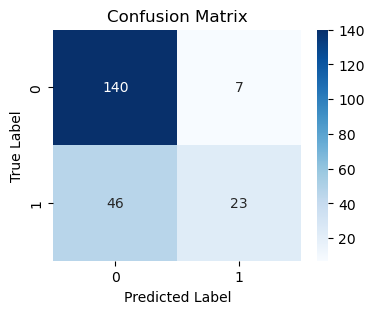

In [12]:

print(f"Small_CNN Test: loss={test_loss:.4f}, acc={test_acc:.4f} \n")
print(classification_report(y_true, y_pred, digits=4))

# Plot confusion matrix as heatmap

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")


plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
import yaml

with open('config.yaml', 'r') as file:
    data = yaml.safe_load(file)
# 'data' will now be a Python dictionary or list

### ResNet

In [39]:
from torchvision import models

# PyTorch 2.x API: use "weights" for pretrained
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Replace final layer for 2 classes
in_feats = resnet.fc.in_features
resnet.fc = nn.Linear(in_feats, 2)

# Option 1 (recommended to start): fine-tune ALL layers
for p in resnet.parameters():
    p.requires_grad = True

resnet.to(device)
resnet


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
resnet, history_resnet = fit(
    resnet,
    loaders,
    epochs=5,         # try 5–15; watch val accuracy
    lr=3e-4,          # slightly smaller LR for pretrained nets
    weight_decay=1e-4
)


[01] train_loss=0.1585 acc=0.9423 | val_loss=0.0259 acc=0.9892 | 14.3s
[02] train_loss=0.0319 acc=0.9895 | val_loss=0.0232 acc=0.9892 | 13.5s
[03] train_loss=0.0335 acc=0.9895 | val_loss=0.0033 acc=1.0000 | 14.0s
[04] train_loss=0.0382 acc=0.9895 | val_loss=0.0252 acc=0.9892 | 13.5s
[05] train_loss=0.0253 acc=0.9885 | val_loss=0.0075 acc=1.0000 | 13.3s


ResNet18 Test: loss=0.0318, acc=0.9907
              precision    recall  f1-score   support

           0     0.9932    0.9932    0.9932       147
           1     0.9855    0.9855    0.9855        69

    accuracy                         0.9907       216
   macro avg     0.9894    0.9894    0.9894       216
weighted avg     0.9907    0.9907    0.9907       216



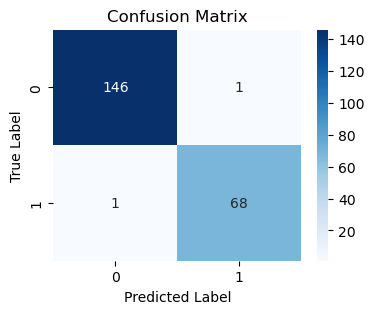

In [42]:
crit = nn.CrossEntropyLoss()
test_loss, test_acc, y_true, y_pred = evaluate(resnet, loaders["test"], crit, device)
print(f"ResNet18 Test: loss={test_loss:.4f}, acc={test_acc:.4f}")
print(classification_report(y_true, y_pred, digits=4))

# print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")


plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()